In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary modules
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
DATA_PATH = r'/home/rlfowler/Documents/research/tfo_inverse_modelling/Randalls Folder/data/randall_data_intensities.pkl'
#CONFIG_PATH = r'/home/rlfowler/Documents/research/tfo_sim/data/compiled_intensity/randall_data.json'

# Load the data
data = pd.read_pickle(DATA_PATH)
print(data.shape)
data.head()

(35929014, 47)


,Maternal Wall Thickness,Fetal Radius,Fetal Displacement,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10.0_1.0,15.0_1.0,19.0_1.0,...,55.0_2.0,59.0_2.0,64.0_2.0,68.0_2.0,72.0_2.0,77.0_2.0,81.0_2.0,86.0_2.0,90.0_2.0,94.0_2.0
43923,2.0,50.0,5.0,11.0,0.9,10.725,0.10,0.000041,0.000005,0.000001,...,6.001589e-15,5.848743e-15,2.763929e-16,1.500358e-17,3.398607e-18,1.015295e-18,7.130597e-20,8.710054e-22,4.012456e-20,2.355748e-22
43924,2.0,50.0,5.0,11.0,0.9,10.725,0.15,0.000041,0.000005,0.000001,...,5.893694e-15,5.768395e-15,2.710312e-16,1.463642e-17,3.212955e-18,9.575111e-19,6.831444e-20,8.155644e-22,3.835888e-20,2.151092e-22
43925,2.0,50.0,5.0,11.0,0.9,10.725,0.20,0.000041,0.000005,0.000001,...,5.789363e-15,5.689761e-15,2.658178e-16,1.428727e-17,3.039417e-18,9.030257e-19,6.545149e-20,7.646231e-22,3.667090e-20,1.964215e-22
43926,2.0,50.0,5.0,11.0,0.9,10.725,0.25,0.000041,0.000005,0.000001,...,5.688417e-15,5.612798e-15,2.607455e-16,1.395518e-17,2.877101e-18,8.516513e-19,6.271132e-20,7.177746e-22,3.505719e-20,1.793575e-22
43927,2.0,50.0,5.0,11.0,0.9,10.725,0.30,0.000041,0.000005,0.000001,...,5.590720e-15,5.537444e-15,2.558081e-16,1.363931e-17,2.725183e-18,8.032090e-19,6.008842e-20,6.746510e-22,3.351450e-20,1.637759e-22


In [4]:
## Scale y
from sklearn import preprocessing

y_columns = data.columns[:7]#["Fetal Saturation"]
x_columns = data.columns[7:]

y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [5]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42    # Set the random seed for reproducibility
SAMPLE_SIZE = 0.05   # Set the sample size from the data
TEST_SIZE = 0.2     # Set the test size for the train/test split

# Split the data into training and testing sets # Might want to remove randomness for param selection
train_data, test_data = train_test_split(data.sample(frac=SAMPLE_SIZE, random_state=RANDOM_SEED) , test_size=TEST_SIZE, random_state=RANDOM_SEED)
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Split the data into input and output
x_train = train_data.iloc[:, 7:]
x_test = test_data.iloc[:, 7:]
y_train = train_data.iloc[:,:7]
y_test = test_data.iloc[:,:7]
print(f"x_train columns: {x_train.columns.tolist()}")
print(f"y_train columns: {y_train.columns.tolist()}")

del data, train_data, test_data

Train data shape: (1437160, 47)
Test data shape: (359291, 47)
x_train columns: ['10.0_1.0', '15.0_1.0', '19.0_1.0', '24.0_1.0', '28.0_1.0', '33.0_1.0', '37.0_1.0', '41.0_1.0', '46.0_1.0', '50.0_1.0', '55.0_1.0', '59.0_1.0', '64.0_1.0', '68.0_1.0', '72.0_1.0', '77.0_1.0', '81.0_1.0', '86.0_1.0', '90.0_1.0', '94.0_1.0', '10.0_2.0', '15.0_2.0', '19.0_2.0', '24.0_2.0', '28.0_2.0', '33.0_2.0', '37.0_2.0', '41.0_2.0', '46.0_2.0', '50.0_2.0', '55.0_2.0', '59.0_2.0', '64.0_2.0', '68.0_2.0', '72.0_2.0', '77.0_2.0', '81.0_2.0', '86.0_2.0', '90.0_2.0', '94.0_2.0']
y_train columns: ['Maternal Wall Thickness', 'Fetal Radius', 'Fetal Displacement', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Hb Concentration', 'Fetal Saturation']


In [7]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32 #128, 32


# Create a dataloader
train_dataset = TensorDataset(torch.tensor(x_train.values, dtype=torch.float32).cuda(), torch.tensor(y_train.values, dtype=torch.float32).cuda())
test_dataset = TensorDataset(torch.tensor(x_test.values, dtype=torch.float32).cuda(), torch.tensor(y_test.values, dtype=torch.float32).cuda())
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Hyperparameters
from typing import Optional, List
from torch.optim import SGD, Optimizer


# Create a neural network
class Net(nn.Module):
    
    layers: List[nn.Module] = []     # List of layers
    model: nn.Module            # The model
    training_loss: List[float] = []  # Training loss
    validation_loss: List[float] = []# Validation loss

    def __init__(self, node_count: List[int], dropout_rates: Optional[List[float]]):
        super(Net, self).__init__()
        #self.layers = []
        for indx, n_nodes in enumerate(node_count[:-2]):
            self.layers.append(nn.Linear(n_nodes, node_count[indx+1]))
            self.layers.append(nn.BatchNorm1d(node_count[indx+1]))
            if dropout_rates:
                self.layers.append(nn.Dropout(dropout_rates[indx]))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(node_count[-2], node_count[-1]))   # Output layer
        self.model = nn.Sequential(*self.layers)
        self.model.cuda()

    def _default_optimizer(self):
        return SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        
    def forward(self, x):
        return self.model(x)
    
    def train(self, train_loader, criterion:nn.Module = nn.MSELoss(), optimizer:Optimizer = None, n_epochs:int = 1, verbose:bool = False):
        if optimizer is None:
            optimizer = self._default_optimizer()
        batch_size = train_loader.batch_size

        self.model.train()  # Set the model to training mode
        print("Starting training...")
        print(f"Length of train_loader: {len(train_loader)}")
        for epoch in range(n_epochs):
            running_loss = 0.0
            for step, (batch_x, batch_y) in enumerate(train_loader):
                #batch_x = batch_x.cuda()    # Send the data to the GPU
                #batch_y = batch_y.cuda()    # Send the data to the GPU

                output = self.forward(batch_x)                      # Forward pass
                loss = criterion(output, batch_y)                   # Compute the loss
                optimizer.zero_grad()                               # Zero the gradients to prevent accumulation
                loss.backward()                                     # Backpropagation to compute the gradients                   
                optimizer.step()                                    # Update the weights, apply gradients        

                running_loss += loss.item()                         # Add the loss to the running loss

                if verbose and step % batch_size == 0:                    # Print stats every 100 steps
                    print(f"Epoch: {epoch}, Step: {step}, Loss: {loss.item()}")
                    # accuracy = torch.sum(torch.abs(output - batch_y) < 0.1).item() / len(batch_y)
                    # print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}")
            self.training_loss.append(running_loss/len(train_loader))  # Append the average loss to the training loss list

    def predict(self, test_loader, criterion:nn.Module = nn.MSELoss(), verbose=False):
        self.model.eval()
        running_loss = 0.0
        accuracy = 0.0
        print("Starting prediction...")
        for step, (batch_x, batch_y) in enumerate(test_loader):
            # Send the data to the GPU
            #batch_x = batch_x.cuda()
            #batch_y = batch_y.cuda()
            
            with torch.no_grad():
                output = self.model(batch_x)
                loss = criterion(output, batch_y)

            # acc = torch.sum(torch.abs(output - batch_y) < 0.1).item() / len(batch_y)
            # accuracy += acc
            running_loss += loss.item()

            if verbose:
                print(f"Loss: {loss.item()}")#, Accuracy: {acc}")

        accuracy /= len(test_loader)
        running_loss /= len(test_loader)
        self.validation_loss.append(running_loss)
        return running_loss, accuracy


In [9]:
dropout_rates = [0.4, 0.4, 0.4] # also try [0.5, 0.5, 0.5]  # Dropout rates for each layer except output
model = Net([x_train.shape[1], 20, 10, 10, y_train.shape[1]], dropout_rates)
model.train(train_loader, verbose=True)
model.predict(test_loader, verbose=True)

Starting training...
Length of train_loader: 44912
Epoch: 0, Step: 0, Loss: 1.3315601348876953
Epoch: 0, Step: 32, Loss: 1.1166224479675293
Epoch: 0, Step: 64, Loss: 1.2391295433044434
Epoch: 0, Step: 96, Loss: 1.0734361410140991
Epoch: 0, Step: 128, Loss: 0.9631526470184326
Epoch: 0, Step: 160, Loss: 0.9375290870666504
Epoch: 0, Step: 192, Loss: 1.0638048648834229
Epoch: 0, Step: 224, Loss: 0.9834450483322144
Epoch: 0, Step: 256, Loss: 0.9580352306365967
Epoch: 0, Step: 288, Loss: 0.9915883541107178
Epoch: 0, Step: 320, Loss: 0.8974120616912842
Epoch: 0, Step: 352, Loss: 0.8971797823905945
Epoch: 0, Step: 384, Loss: 0.8957464098930359
Epoch: 0, Step: 416, Loss: 0.9657041430473328
Epoch: 0, Step: 448, Loss: 0.9558357000350952
Epoch: 0, Step: 480, Loss: 1.0993008613586426
Epoch: 0, Step: 512, Loss: 1.07612943649292
Epoch: 0, Step: 544, Loss: 0.8828185796737671
Epoch: 0, Step: 576, Loss: 0.9765637516975403
Epoch: 0, Step: 608, Loss: 1.0363538265228271
Epoch: 0, Step: 640, Loss: 0.8829920

(0.7465801347945566, 0.0)

In [13]:
print(model)

Net(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=7, bias=True)
  )
)


In [14]:
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       820
│    └─BatchNorm1d: 2-2                  40
│    └─Dropout: 2-3                      --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       210
│    └─BatchNorm1d: 2-6                  20
│    └─Dropout: 2-7                      --
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       110
│    └─BatchNorm1d: 2-10                 20
│    └─Dropout: 2-11                     --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      77
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0

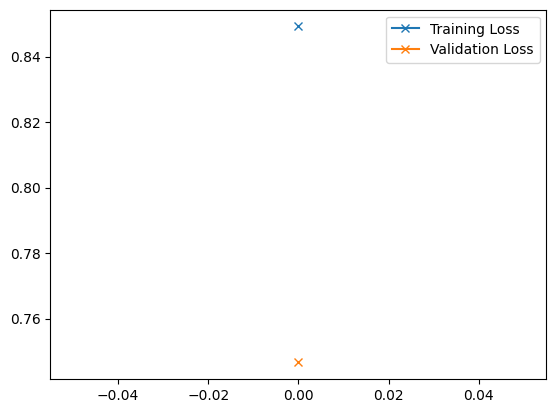

In [12]:
plt.figure()
plt.plot(model.training_loss, label='Training Loss', marker='x')
plt.plot(model.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
# plt.xlim([0, 10])
plt.legend()

In [15]:
print(model.training_loss)
print(model.validation_loss)

[0.8492019220358501]
[0.7465801347945566]


In [16]:
import joblib

model_name = "model1"

# Save the model weights
torch.save(model.state_dict(), rf'models/{model_name}_weights.pth')
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler') # stores in folder 2 levels up and in models folder
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')
joblib.dump(x_scaler, rf'models/{model_name}_xscaler')
joblib.dump(y_scaler, rf'models/{model_name}_yscaler')

['models/model1_yscaler']

In [ ]:
# Increase batch_size for faster visuals generation - (does not affect training!)
from inverse_modelling_tfo.visualization.distributions import generate_model_error_and_prediction

trainer.change_batch_size(4096)
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

## Load Data

Make sure the old model doesn't exist here. Not sure why but new model will contain old model layers. Cannot create new model while old model exists...

In [19]:
dropout_rates = [0.4, 0.4, 0.4]

model_name = "model1"

# Create an instance of the model
new_model = Net([40, 20, 10, 10, 7], dropout_rates)
print(new_model)

# Load the saved weights
model_weights = rf'models/{model_name}_weights.pth'
new_model.load_state_dict(torch.load(model_weights))

Net(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=7, bias=True)
    (13): Linear(in_features=40, out_features=20, bias=True)
    (14): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.4, inplace=False)
    (16): ReLU()
    (17): Linear(in_features=20, out_features=10, bias=True)
    (18): BatchNorm1d(10, eps

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "model.13.weight", "model.13.bias", "model.14.weight", "model.14.bias", "model.14.running_mean", "model.14.running_var", "model.17.weight", "model.17.bias", "model.18.weight", "model.18.bias", "model.18.running_mean", "model.18.running_var", "model.21.weight", "model.21.bias", "model.22.weight", "model.22.bias", "model.22.running_mean", "model.22.running_var", "model.25.weight", "model.25.bias", "model.26.weight", "model.26.bias", "model.27.weight", "model.27.bias", "model.27.running_mean", "model.27.running_var", "model.30.weight", "model.30.bias", "model.31.weight", "model.31.bias", "model.31.running_mean", "model.31.running_var", "model.34.weight", "model.34.bias", "model.35.weight", "model.35.bias", "model.35.running_mean", "model.35.running_var", "model.38.weight", "model.38.bias". 